## TODO

Note class imbalance (https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

In [12]:
!pip install --user pandas seaborn pandas_ml -U # Needed in https://github.com/jupyter/docker-stacks/tree/master/datascience-notebook

Requirement already up-to-date: pandas in /home/jovyan/.local/lib/python3.6/site-packages
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.6/site-packages
Requirement already up-to-date: pandas_ml in /home/jovyan/.local/lib/python3.6/site-packages
Requirement already up-to-date: pytz>=2011k in /opt/conda/lib/python3.6/site-packages (from pandas)
Requirement already up-to-date: numpy>=1.9.0 in /home/jovyan/.local/lib/python3.6/site-packages (from pandas)
Requirement already up-to-date: python-dateutil>=2 in /opt/conda/lib/python3.6/site-packages (from pandas)
Requirement already up-to-date: enum34 in /home/jovyan/.local/lib/python3.6/site-packages (from pandas_ml)
Requirement already up-to-date: six>=1.5 in /opt/conda/lib/python3.6/site-packages (from python-dateutil>=2->pandas)


In [13]:
%%bash
# These files appear to be from the original competition (that is unmodified)
wget -q -c https://raw.githubusercontent.com/yasminlucero/Kaggle/master/Data/compDataAsSQLiteDB/compData.db
wget -q -c https://raw.githubusercontent.com/yasminlucero/Kaggle/master/Data/compDataAsSQLiteDB/compData.sql

In [14]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm

import sqlite3
import pandas as pd
import numpy as np

from patsy import dmatrices

from contextlib import closing

from pandas_ml import ConfusionMatrix

from pandas.api.types import CategoricalDtype

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

py.init_notebook_mode()

In [15]:
seed = 13431
np.random.seed(seed)

with closing(sqlite3.connect('file:compData.db?mode=ro', uri=True)) as conn:    
    patientTranscripts = pd.read_sql_query("""
    SELECT PatientGuid,
        dmIndicator,
        Gender,
        YearOfBirth,
        VisitYear,
        CASE WHEN BMI = 0 THEN NULL ELSE BMI END AS BMI,
        CASE WHEN SystolicBP = 'NULL' THEN NULL ELSE SystolicBP END AS SystolicBP,
        CASE WHEN DiastolicBP = 'NULL' THEN NULL ELSE DiastolicBP END AS DiastolicBP
    FROM training_patientTranscript
""", conn)

In [164]:
# https://www.cdc.gov/healthyweight/assessing/index.html
# https://en.wikipedia.org/wiki/Classification_of_obesity
def translateBMI(bmi):
    if bmi <  18.5:
        return 'Underweight'
    elif 18.5 <= bmi <= 24.9:
        return  'Normal'
    elif 25 <= bmi <= 29.9:
        return 'Overweight'
    elif 30 <= bmi <= 34.9:
        return 'Class 1'
    elif 35 <= bmi <= 39.9:
        return 'Class 2'
    else:
        return 'Class 3'
        
# https://www.heart.org/HEARTORG/Conditions/HighBloodPressure/KnowYourNumbers/Understanding-Blood-Pressure-Readings_UCM_301764_Article.jsp
def translateBP(systolicBP, diastolicBP):
    if systolicBP < 120 and diastolicBP < 80:
        return 'Normal'
    elif systolicBP <= 129 and diastolicBP < 80:
        return 'Elevated'
    elif systolicBP <= 139 or 80 <= diastolicBP <= 89:
        return 'Stage 1'
    elif 140 <= systolicBP or 90 <= diastolicBP:
        return 'Stage 2'
    else:
        return 'HT Crisis'
    
def calcAge(yearOfBirth):
    return 2012 - yearOfBirth

# One of these is prediabetes and the other is gestational diabetes
def isPreDB(conn):
    return pd.read_sql_query(f"SELECT DISTINCT PatientGuid, 1 AS PreDB FROM training_diagnosis WHERE ICD9Code IN ('790.29','648.83')", conn)

def hasFhxDM(conn):
    return pd.read_sql_query(f"SELECT DISTINCT PatientGuid, 1 AS FhxDM FROM training_diagnosis WHERE ICD9Code == 'V18.0'", conn)

# 272.4: Dyslipidemia (Abnormal LDL, HDL, or triglycerides, increasking risk for heart attack)
# 571.8 and 571.9: Nonalcholic fatty liver disease (NAFLD)
# 429.2: Cardiovascular disease
# 585: Kidney disease
# 250.5: retinopathy
# 401-405: Hypertension (high blood pressure)
# 278: Obesity
# 701.2: Acquired acanthosis nigricans
def hasComorbidities(conn):
    return pd.read_sql_query(f"SELECT DISTINCT PatientGuid, 1 AS CC FROM training_diagnosis WHERE ICD9Code LIKE '585%' OR ICD9Code IN ('272.4', '571.8', '571.9', '429.2', '250.5', '278', '701.2')", conn)

def isHeavySmoker(conn):
    # Note: Need to use training_patientSmokingStatus directly rather than patient_smoking
    # as the NIST codes used translate to multiple statuses (1:N)
    return pd.read_sql_query(f"SELECT DISTINCT PatientGuid, 1 AS HeavySmoker FROM training_patientSmokingStatus WHERE SmokingStatusGuid IN ('02116D5A-F26C-4A48-9A11-75AC21BC4FD3', 'FCD437AA-0451-4D8A-9396-B6F19D8B25E8')", conn)

def hasHighTG(conn):
    return pd.read_sql_query(f"SELECT DISTINCT PatientGuid, 1 AS HighTG FROM training_labs WHERE HL7Identifier == '2571-8' AND AbnormalFlags LIKE 'Above%'", conn)

def processPatientTranscripts(pt):
    with closing(sqlite3.connect('file:compData.db?mode=ro', uri=True)) as conn:    
        pt = pt.sort_values(['VisitYear'],  ascending=False)
        pt = pt.groupby('PatientGuid', as_index=False).agg(lambda x: np.nan if x.first_valid_index() is None else x.loc[x.first_valid_index()])

        pt['dmIndicator'] = pt['dmIndicator'].astype('bool')
        pt['Gender'] = pt['Gender'].astype('category')
        pt['Age'] = pt.apply(lambda row: calcAge(row.YearOfBirth), axis=1)

        pt.drop(['VisitYear', 'YearOfBirth'], axis=1, inplace=True)
        pt.dropna(how='any', inplace=True)

        bmi_type = CategoricalDtype(categories=['Underweight', 'Normal', 'Overweight', 'Class 1', 'Class 2', 'Class 3'], ordered=True)
        pt['BMICategory'] = pt.apply(lambda row: translateBMI(row.BMI), axis=1).astype(bmi_type)
        pt['Obese'] = pt.apply(lambda row: row.BMI >= 30, axis=1)
        bp_type = CategoricalDtype(categories=['Normal', 'Elevated', 'Stage 1', 'Stage 2'], ordered=True)
        pt['BPCategory'] = pt.apply(lambda row: translateBP(row.SystolicBP, row.DiastolicBP), axis=1).astype(bp_type)
        pt['HT'] = pt.apply(lambda row: row.BPCategory not in ('Normal', 'Elevated'), axis=1)

        preDB = isPreDB(conn)
        pt = pd.merge(pt, preDB, on='PatientGuid', how='left')
        pt['PreDB'] = pt['PreDB'].fillna(False).astype('bool')

        fhxDM = hasFhxDM(conn)
        pt = pd.merge(pt, fhxDM, on='PatientGuid', how='left')
        pt['FhxDM'] = pt['FhxDM'].fillna(False).astype('bool')
        
        highTG = hasHighTG(conn)
        pt = pd.merge(pt, highTG, on='PatientGuid', how='left')
        pt['HighTG'] = pt['HighTG'].fillna(False).astype('bool')

        cc = hasComorbidities(conn)
        pt = pd.merge(pt, cc, on='PatientGuid', how='left')
        pt['CC'] = pt['CC'].fillna(False).astype('bool')

        hs = isHeavySmoker(conn)
        pt = pd.merge(pt, hs, on='PatientGuid', how='left')
        pt['HeavySmoker'] = pt['HeavySmoker'].fillna(False).astype('bool')
        
        pt['SystolicBP'] = pt['SystolicBP'].astype('int')
        pt['DiastolicBP'] = pt['DiastolicBP'].astype('int')

        # Normalizing some outrageously low and high BMI values. May want to drop these instead.
        #pt.loc[(pt['BMI'] < 10) | (pt['BMI'] > 100), 'BMI'] = pt.BMI.mean()
        pt = pt[(pt.BMI >= 10) & (pt.BMI <= 100)]

        # Bin ages
        labels = [ "{0} - {1}".format(i, i + 4) for i in range(15, 95, 5) ]
        pt['AgeGroup'] = pd.cut(pt.Age, range(15, 100, 5), right=False, labels=labels).astype('category')

        return pt

In [165]:
patientTranscripts.describe()

dmIndicator    YearOfBirth      VisitYear            BMI  \
count  131031.000000  131031.000000  131031.000000   59395.000000   
mean        0.233792    1955.756905    1949.763529      46.729406   
std         0.423243      17.471336     343.929865    2348.963953   
min         0.000000    1922.000000       0.000000       0.076000   
25%         0.000000    1943.000000    2010.000000      24.656000   
50%         0.000000    1955.000000    2010.000000      28.614000   
75%         0.000000    1969.000000    2011.000000      33.295000   
max         1.000000    1994.000000    2012.000000  549746.000000   

         SystolicBP   DiastolicBP  
count  85580.000000  85580.000000  
mean     126.728523     76.600760  
std       17.527290     11.493509  
min       10.000000      1.000000  
25%      116.000000     70.000000  
50%      126.000000     78.000000  
75%      138.000000     82.000000  
max      270.000000    990.000000

In [166]:
len(patientTranscripts.PatientGuid.unique())

9948

In [167]:
patientTranscripts.head(30)

PatientGuid  dmIndicator Gender  YearOfBirth  \
0   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
1   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
2   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
3   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
4   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
5   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
6   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
7   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
8   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
9   FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
10  FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
11  FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
12  FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
13  FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
14  FB6EFC3D-1A20-4497-9CBD-00027CC5D220            0      M         1929   
15  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
16  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
17  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
18  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
19  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
20  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
21  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
22  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
23  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
24  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
25  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
26  C6746626-6783-4650-A58F-00065649139A            0      F         1985   
27  E05C6E8F-779F-4594-A388-000C635AE4D3            0      F         1984   
28  E05C6E8F-779F-4594-A388-000C635AE4D3            0      F         1984   
29  E05C6E8F-779F-4594-A388-000C635AE4D3            0      F         1984   

    VisitYear     BMI  SystolicBP  DiastolicBP  
0        2009  18.900       134.0         72.0  
1        2009     NaN         NaN          NaN  
2        2009     NaN         NaN          NaN  
3        2011     NaN       132.0         80.0  
4        2009     NaN         NaN          NaN  
5        2010     NaN       130.0         74.0  
6        2009  18.900         NaN          NaN  
7        2010     NaN         NaN          NaN  
8        2009     NaN       120.0         60.0  
9        2009     NaN         NaN          NaN  
10       2010     NaN         NaN          NaN  
11       2011     NaN       142.0         71.0  
12       2010     NaN         NaN          NaN  
13       2011     NaN       136.0         86.0  
14       2009  19.343       142.0         66.0  
15       2011     NaN        99.0         66.0  
16       2011     NaN       108.0         65.0  
17       2011     NaN         NaN          NaN  
18       2011     NaN       108.0         64.0  
19       2011     NaN       110.0         72.0  
20       2010     NaN         NaN          NaN  
21       2012  25.753       112.0         60.0  
22       2011     NaN       118.0         66.0  
23       2010     NaN       112.0         60.0  
24       2011     NaN       112.0         68.0  
25       2011     NaN       112.0         74.0  
26       2011  27.025       103.0         68.0  
27       2011     NaN         NaN          NaN  
28       2010     NaN         NaN          NaN  
29       2011     NaN         NaN          NaN

In [188]:
patients = processPatientTranscripts(patientTranscripts)
patients.head()

PatientGuid  dmIndicator Gender     BMI  \
0  00023761-9D8D-445B-874C-2424CC7CF620        False      M  27.670   
1  0005D9BD-0247-4F02-B7EE-7C1B44825FA1        False      F  22.463   
2  000B4862-7CE7-4EC5-8043-A97FCD74BD78        False      F  16.654   
3  00110ABC-DAB9-49E3-A1C8-88BBF8D58109        False      M  28.190   
4  002667F4-B9A3-4DE2-875F-8034DD637865        False      F  19.388   

   SystolicBP  DiastolicBP  Age  BMICategory  Obese BPCategory     HT  PreDB  \
0         122           76   56   Overweight  False   Elevated  False  False   
1         128           82   60       Normal  False    Stage 1   True  False   
2          80           60   87  Underweight  False     Normal  False  False   
3         125           75   42   Overweight  False   Elevated  False  False   
4         112           80   84       Normal  False    Stage 1   True  False   

   FhxDM  HighTG     CC  HeavySmoker AgeGroup  
0  False   False  False        False  55 - 59  
1  False   False  False        False  60 - 64  
2  False   False  False        False  85 - 89  
3  False   False  False        False  40 - 44  
4  False   False  False        False  80 - 84

In [189]:
patients.describe()

BMI   SystolicBP  DiastolicBP          Age
count  9921.000000  9921.000000  9921.000000  9921.000000
mean     28.973770   126.318315    76.761516    54.595908
std       6.272264    17.211811    10.901482    17.495475
min      10.804000    30.000000     1.000000    18.000000
25%      24.481000   115.000000    70.000000    42.000000
50%      28.189000   125.000000    78.000000    55.000000
75%      32.768000   136.000000    83.000000    68.000000
max      93.223000   270.000000   155.000000    90.000000

In [190]:
patients.drop(['PatientGuid'], axis=1, inplace=True)
patients.head()

dmIndicator Gender     BMI  SystolicBP  DiastolicBP  Age  BMICategory  \
0        False      M  27.670         122           76   56   Overweight   
1        False      F  22.463         128           82   60       Normal   
2        False      F  16.654          80           60   87  Underweight   
3        False      M  28.190         125           75   42   Overweight   
4        False      F  19.388         112           80   84       Normal   

   Obese BPCategory     HT  PreDB  FhxDM  HighTG     CC  HeavySmoker AgeGroup  
0  False   Elevated  False  False  False   False  False        False  55 - 59  
1  False    Stage 1   True  False  False   False  False        False  60 - 64  
2  False     Normal  False  False  False   False  False        False  85 - 89  
3  False   Elevated  False  False  False   False  False        False  40 - 44  
4  False    Stage 1   True  False  False   False  False        False  80 - 84

## TODO 
Replace individual plots with a group plot

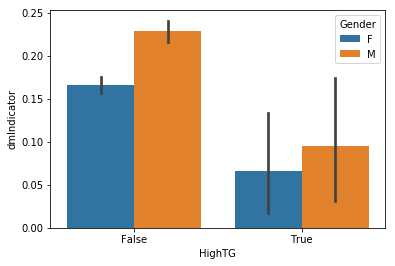

In [191]:
sns.barplot(x="HighTG", y="dmIndicator", hue="Gender", data=patients);

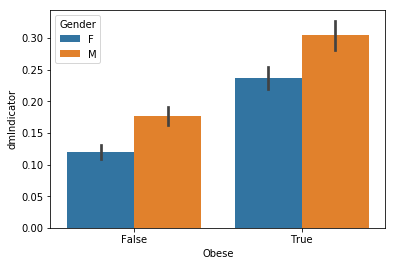

In [192]:
sns.barplot(x="Obese", y="dmIndicator", hue="Gender", data=patients);

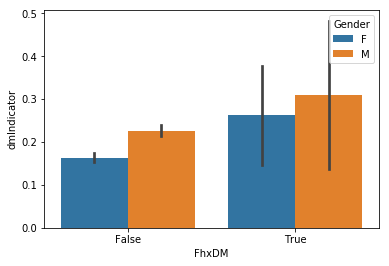

In [193]:
sns.barplot(x="FhxDM", y="dmIndicator", hue="Gender", data=patients);

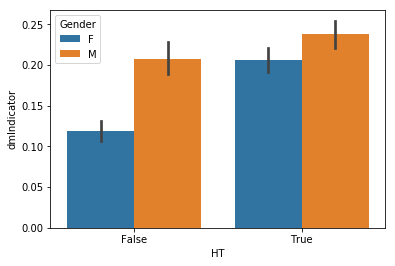

In [194]:
sns.barplot(x="HT", y="dmIndicator", hue="Gender", data=patients);

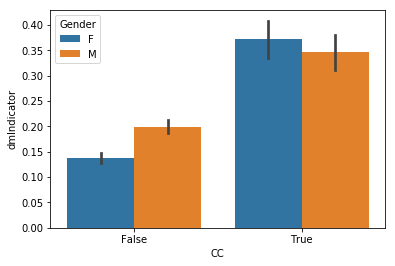

In [195]:
sns.barplot(x="CC", y="dmIndicator", hue="Gender", data=patients);

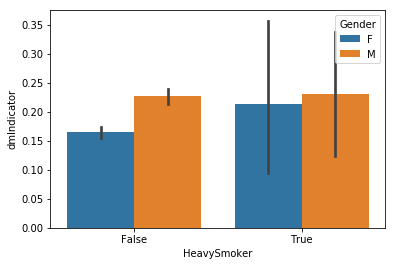

In [196]:
sns.barplot(x="HeavySmoker", y="dmIndicator", hue="Gender", data=patients);

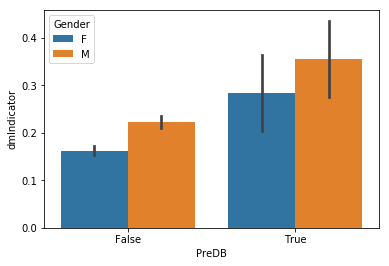

In [197]:
sns.barplot(x="PreDB", y="dmIndicator", hue="Gender", data=patients);

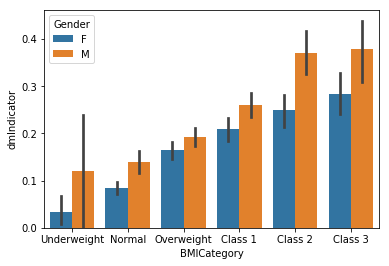

In [198]:
sns.barplot(x="BMICategory", y="dmIndicator", hue="Gender", data=patients);

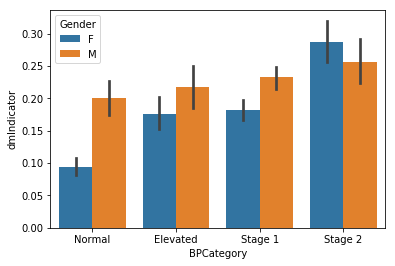

In [199]:
sns.barplot(x="BPCategory", y="dmIndicator", hue="Gender", data=patients);

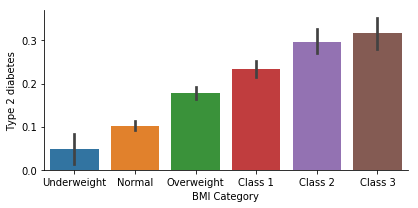

In [200]:
sns.factorplot(x="BMICategory", y="dmIndicator", data=patients, kind="bar", size=3, aspect=2);

plt.xlabel('BMI Category')
plt.ylabel('Type 2 diabetes');

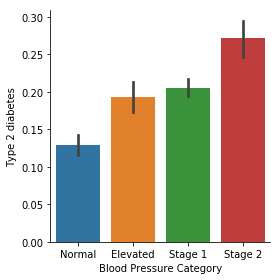

In [201]:
sns.factorplot(x="BPCategory", y="dmIndicator", data=patients, kind="bar")
plt.xlabel('Blood Pressure Category')
plt.ylabel('Type 2 diabetes');

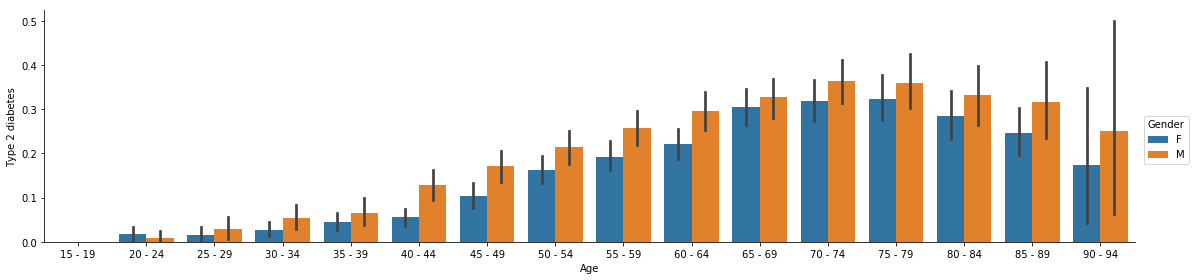

In [202]:
sns.factorplot(x="AgeGroup", y="dmIndicator", data=patients, kind="bar",  hue="Gender", size=4, aspect=4)
plt.xlabel('Age')
plt.ylabel('Type 2 diabetes');

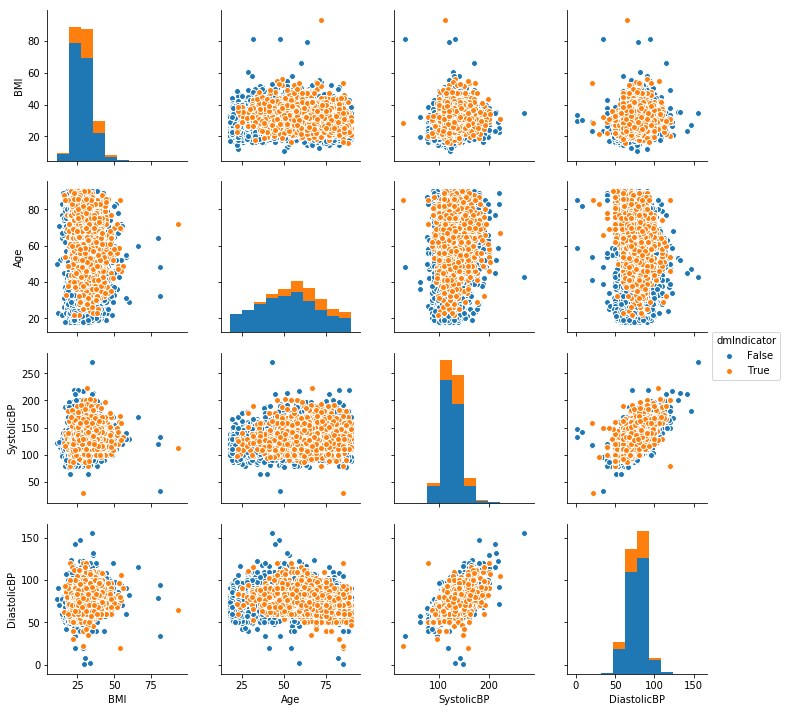

In [203]:
sns.pairplot(patients, vars=['BMI', 'Age', 'SystolicBP', 'DiastolicBP'], hue='dmIndicator', size=2.5);

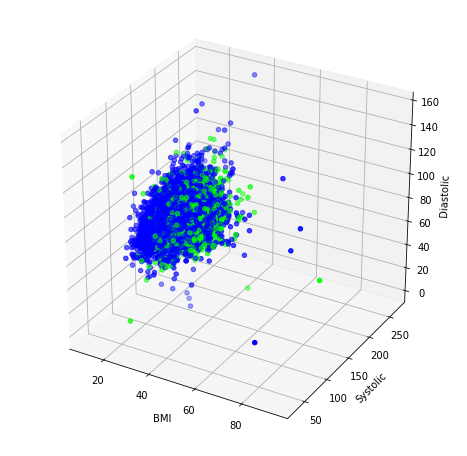

In [204]:
threeDScatter = plt.figure(figsize=(8,8)).gca(projection='3d')
threeDScatter.scatter(patients['BMI'], patients['SystolicBP'], patients['DiastolicBP'], c=patients['dmIndicator'], cmap = 'brg')
threeDScatter.set_xlabel('BMI')
threeDScatter.set_ylabel('Systolic')
threeDScatter.set_zlabel('Diastolic')
plt.show()

## BMI Effect

In [205]:
y, X = dmatrices('dmIndicator ~ Obese + HT + C(Gender) + C(AgeGroup) + PreDB + FhxDM + HeavySmoker + CC + HighTG', patients, return_type='dataframe')
y = patients.values[:, 0].astype('bool')

In [206]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=seed)

In [207]:
lr = LogisticRegressionCV()
lr.fit(train_X, train_y)

print("Accuracy = {:.2f}".format(lr.score(test_X, test_y)))

Accuracy = 0.82


In [208]:
y.mean()

0.19131135974196151

Only 19% of the patients had type 2 diabetes, which means that we could obtain 81% accuracy by always predicting `False`. So we're actually doing *worse* than the null error rate.

In [209]:
pd.DataFrame(list(zip(X.columns, np.transpose(lr.coef_))))

0                   1
0                Intercept  [-0.0157616643276]
1            Obese[T.True]    [0.798626014376]
2               HT[T.True]    [0.183677170244]
3           C(Gender)[T.M]    [0.301944371934]
4   C(AgeGroup)[T.20 - 24]    [-1.48319219583]
5   C(AgeGroup)[T.25 - 29]    [-1.30780517304]
6   C(AgeGroup)[T.30 - 34]   [-0.958240089623]
7   C(AgeGroup)[T.35 - 39]    [-0.78641337811]
8   C(AgeGroup)[T.40 - 44]   [-0.431877284892]
9   C(AgeGroup)[T.45 - 49]   [0.0610908420235]
10  C(AgeGroup)[T.50 - 54]    [0.338517791233]
11  C(AgeGroup)[T.55 - 59]    [0.591624778616]
12  C(AgeGroup)[T.60 - 64]    [0.804247037222]
13  C(AgeGroup)[T.65 - 69]     [1.11390867908]
14  C(AgeGroup)[T.70 - 74]     [1.21467871963]
15  C(AgeGroup)[T.75 - 79]     [1.13938633478]
16  C(AgeGroup)[T.80 - 84]     [1.11523794426]
17  C(AgeGroup)[T.85 - 89]     [1.05221182669]
18  C(AgeGroup)[T.90 - 94]    [0.454208824144]
19           PreDB[T.True]    [0.546015567463]
20           FhxDM[T.True]    [0.765484480819]
21     HeavySmoker[T.True]   [0.0712463428661]
22              CC[T.True]    [0.684877216658]
23          HighTG[T.True]    [-1.07274102367]

In [210]:
binary_confusion_matrix = ConfusionMatrix(test_y, lr.predict(test_X))
print("Binary confusion matrix:\n%s" % binary_confusion_matrix)

Binary confusion matrix:
Predicted  False  True  __all__
Actual                         
False       1598    26     1624
True         324    37      361
__all__     1922    63     1985


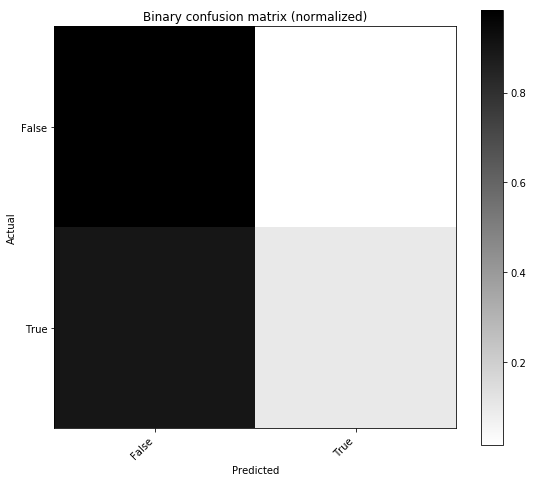

In [211]:
binary_confusion_matrix.plot(normalized=True);

In [212]:
py.iplot(ff.create_distplot([patients.loc[~patients['dmIndicator'], 'BMI'],
                            patients.loc[patients['dmIndicator'], 'BMI']], 
                            group_labels=['Non Diabetic', 'Diabetic']))

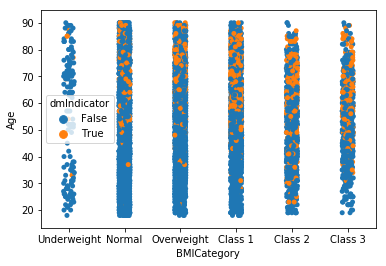

In [213]:
sns.stripplot(x="BMICategory", y="Age", hue="dmIndicator", data=patients, jitter=True);